In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
!pip install afinn
!pip install pmdarima

/kaggle/input/values-of-top-nasdaq-copanies-from-2010-to-2020/CompanyValues.csv
/kaggle/input/values-of-top-nasdaq-copanies-from-2010-to-2020/Company.csv
/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company_Tweet.csv
/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Tweet.csv
/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company.csv
/kaggle/input/stockvalues1111/stock_saved1.csv
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=88ab6ae60734901bbceedd58621e4d895e1be04422f13be60f01e35412578d3f
  Stored in directory: /root/.cache/pip/wheels/b0/05/90/43f79196199a138fb486902fceca30a2d1b5228e6d2db8eb90
Successfully built afinn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.1 MB/s eta 0:00:00


In [2]:
from afinn import Afinn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from wordcloud import WordCloud




/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11cha

In [3]:
company_tweet = pd.read_csv('/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company_Tweet.csv')
tweet = pd.read_csv('/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Tweet.csv')
company = pd.read_csv('/kaggle/input/tweets-about-the-top-companies-from-2015-to-2020/Company.csv')
company_value = pd.read_csv('/kaggle/input/values-of-top-nasdaq-copanies-from-2010-to-2020/CompanyValues.csv')

In [4]:
print(company_tweet.head())
print(company_tweet.shape)

             tweet_id ticker_symbol
0  550803612197457920          AAPL
1  550803610825928706          AAPL
2  550803225113157632          AAPL
3  550802957370159104          AAPL
4  550802855129382912          AAPL
(4336445, 2)


In [5]:
print(company.head())
print(company.shape)


  ticker_symbol company_name
0          AAPL        apple
1          GOOG   Google Inc
2         GOOGL   Google Inc
3          AMZN   Amazon.com
4          TSLA    Tesla Inc
(6, 2)


In [6]:
print(company_value.head())
print(company_value.shape)

  ticker_symbol    day_date  close_value    volume  open_value  high_value  \
0          AAPL  2020-05-29       317.94  38399530      319.25      321.15   
1          AAPL  2020-05-28       318.25  33449100      316.77      323.44   
2          AAPL  2020-05-27       318.11  28236270      316.14      318.71   
3          AAPL  2020-05-26       316.73  31380450      323.50      324.24   
4          AAPL  2020-05-22       318.89  20450750      315.77      319.23   

   low_value  
0     316.47  
1     315.63  
2     313.09  
3     316.50  
4     315.35  
(17528, 7)


In [7]:
print(tweet.head())
print(tweet.shape)

             tweet_id           writer   post_date  \
0  550441509175443456  VisualStockRSRC  1420070457   
1  550441672312512512      KeralaGuy77  1420070496   
2  550441732014223360      DozenStocks  1420070510   
3  550442977802207232     ShowDreamCar  1420070807   
4  550443807834402816     i_Know_First  1420071005   

                                                body  comment_num  \
0  lx21 made $10,008  on $AAPL -Check it out! htt...            0   
1  Insanity of today weirdo massive selling. $aap...            0   
2  S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...            0   
3  $GM $TSLA: Volkswagen Pushes 2014 Record Recal...            0   
4  Swing Trading: Up To 8.91% Return In 14 Days h...            0   

   retweet_num  like_num  
0            0         1  
1            0         0  
2            0         0  
3            0         1  
4            0         1  
(3717964, 7)


In [8]:
tweet.head()

,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [9]:
tweet.describe

<bound method NDFrame.describe of                     tweet_id           writer   post_date  \
0         550441509175443456  VisualStockRSRC  1420070457   
1         550441672312512512      KeralaGuy77  1420070496   
2         550441732014223360      DozenStocks  1420070510   
3         550442977802207232     ShowDreamCar  1420070807   
4         550443807834402816     i_Know_First  1420071005   
...                      ...              ...         ...   
3717959  1212159765914079234        TEEELAZER  1577836383   
3717960  1212159838882533376    ShortingIsFun  1577836401   
3717961  1212160015332728833      Commuternyc  1577836443   
3717962  1212160410692046849      MoriaCrypto  1577836537   
3717963  1212160477159206912         treabase  1577836553   

                                                      body  comment_num  \
0        lx21 made $10,008  on $AAPL -Check it out! htt...            0   
1        Insanity of today weirdo massive selling. $aap...            0   
2       

In [10]:
company_value.describe

<bound method NDFrame.describe of       ticker_symbol    day_date  close_value    volume  open_value  \
0              AAPL  2020-05-29       317.94  38399530      319.25   
1              AAPL  2020-05-28       318.25  33449100      316.77   
2              AAPL  2020-05-27       318.11  28236270      316.14   
3              AAPL  2020-05-26       316.73  31380450      323.50   
4              AAPL  2020-05-22       318.89  20450750      315.77   
...             ...         ...          ...       ...         ...   
17523          TSLA  2019-12-21       405.59  14785210      410.29   
17524          TSLA  2019-12-22       405.59  14785210      410.29   
17525          TSLA  2019-12-25       425.25   8054720      418.36   
17526          TSLA  2019-12-28       430.38   9956827      435.00   
17527          TSLA  2019-12-29       430.38   9956827      435.00   

       high_value  low_value  
0          321.15   316.4700  
1          323.44   315.6300  
2          318.71   313.0900  
3

EDA

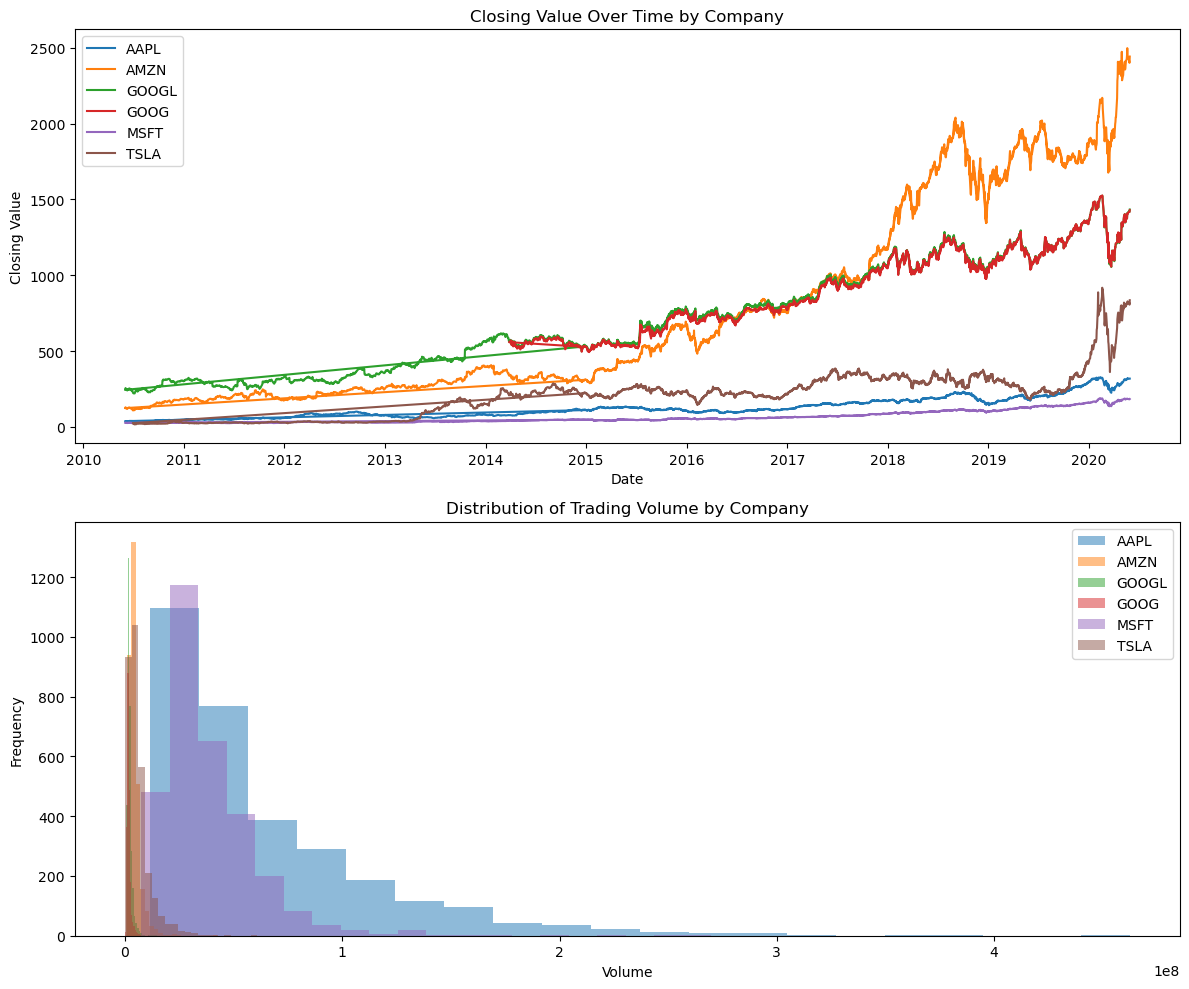

In [11]:
# Setting up the figure and axis
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plotting the closing values over time for each company
for ticker in company_value['ticker_symbol'].unique():
    subset = company_value[company_value['ticker_symbol'] == ticker]
    ax[0].plot(pd.to_datetime(subset['day_date']), subset['close_value'], label=ticker)

ax[0].set_title('Closing Value Over Time by Company')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Closing Value')
ax[0].legend()

# Displaying the distribution of trading volume for each company
for ticker in company_value['ticker_symbol'].unique():
    subset = company_value[company_value['ticker_symbol'] == ticker]
    ax[1].hist(subset['volume'], bins=20, alpha=0.5, label=ticker)

ax[1].set_title('Distribution of Trading Volume by Company')
ax[1].set_xlabel('Volume')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.tight_layout()
plt.show()

In [12]:
# Descriptive statistics for the CompanyValues dataset
for ticker in company_value['ticker_symbol'].unique():
    subset = company_value[company_value['ticker_symbol'] == ticker].describe()
    print(subset)



       close_value        volume   open_value   high_value    low_value
count  3085.000000  3.085000e+03  3085.000000  3085.000000  3085.000000
mean    127.031672  6.349523e+07   126.996091   128.173068   125.823986
std      62.746604  5.083283e+07    62.601952    63.335413    62.035585
min      34.275700  1.136205e+07    34.005700    34.658600    33.651400
25%      77.998500  2.787622e+07    78.310000    78.867100    77.202800
50%     113.400000  4.455079e+07   113.380000   114.362600   112.270000
75%     170.150000  8.350960e+07   170.490000   171.750000   169.000000
max     327.200000  4.624423e+08   324.740000   327.850000   323.350000
       close_value        volume   open_value   high_value    low_value
count  3085.000000  3.085000e+03  3085.000000  3085.000000  3085.000000
mean    821.089846  4.409763e+06   821.794921   829.520278   812.484508
std     630.856062  2.648079e+06   631.680423   637.426105   624.407077
min     108.610000  8.813370e+05   105.925000   111.290000   105

In [13]:
tweet_df = pd.merge(company_tweet , tweet , on="tweet_id", how= "inner")
print(tweet_df.head(5))
print(tweet_df.shape)

             tweet_id ticker_symbol      writer   post_date  \
0  550803612197457920          AAPL  SentiQuant  1420156789   
1  550803612197457920          AMZN  SentiQuant  1420156789   
2  550803610825928706          AAPL  SentiQuant  1420156788   
3  550803610825928706         GOOGL  SentiQuant  1420156788   
4  550803610825928706          AMZN  SentiQuant  1420156788   

                                                body  comment_num  \
0  #TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...            0   
1  #TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...            0   
2  #SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...            0   
3  #SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...            0   
4  #SENTISHIFTUP $K $FB $GOOGL $GS $GOLD $T $AAPL...            0   

   retweet_num  like_num  
0            0         1  
1            0         1  
2            0         1  
3            0         1  
4            0         1  
(4336445, 8)


In [14]:
null_values = tweet_df.isnull().sum()
print(null_values)
null_values_1 = company_value.isnull().sum()
print(null_values_1)

tweet_id             0
ticker_symbol        0
writer           55919
post_date            0
body                 0
comment_num          0
retweet_num          0
like_num             0
dtype: int64
ticker_symbol    0
day_date         0
close_value      0
volume           0
open_value       0
high_value       0
low_value        0
dtype: int64


In [15]:
tweet_df['post_date'] = pd.to_datetime(tweet_df['post_date'], unit='s')
tweet_df['day_date'] = pd.to_datetime(tweet_df['post_date'].apply(lambda date: date.date()))
tweet_df = tweet_df.sort_values(by="day_date")
tt= tweet_df.head(1000000)

In [16]:
ticker_symbol = "AAPL"
data = tt[tt['ticker_symbol'] == ticker_symbol]
data.head(10)

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,day_date
0,550803612197457920,AAPL,SentiQuant,2015-01-01 23:59:49,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01
370,550447574285418497,AAPL,btcgemini,2015-01-01 00:25:03,We searched through hundreds of charts and fou...,0,0,0,2015-01-01
371,550445850170642432,AAPL,JorelLaraKalel,2015-01-01 00:18:12,@CNBC 15 Top #trades for #2015 #FastMoney $TIF...,0,0,2,2015-01-01
372,550445066444369921,AAPL,Bidnessetc,2015-01-01 00:15:05,Apple filed for its own stylus patent in 2010 ...,0,0,0,2015-01-01
373,550444970738335744,AAPL,espositooooo,2015-01-01 00:14:42,“@WSJ: Apple is being sued for falsely adverti...,0,0,0,2015-01-01
374,550444969924653056,AAPL,AppleNewsAAPL,2015-01-01 00:14:42,$AAPL Apple goes global with 'Start Something ...,0,0,1,2015-01-01
375,550444112328261632,AAPL,GetAOM,2015-01-01 00:11:17,$UNP $ORCL $QCOM $MSFT $AAPL Top scoring mega ...,0,0,0,2015-01-01
377,550443858010861568,AAPL,IKFResearch,2015-01-01 00:10:17,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,2015-01-01
379,550443857692078081,AAPL,Gold_prediction,2015-01-01 00:10:17,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,2015-01-01
381,550443857595600896,AAPL,iknowfirst_br,2015-01-01 00:10:17,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1,2015-01-01


In [17]:


# Filter data for a specific ticker symbol, e.g., "AAPL"
ticker_symbol = "AAPL"
data = tt[tt['ticker_symbol'] == ticker_symbol]


# Calculate and print statistical measures
#mean_value = data.mean()
#median_value = data.median()
#standard_deviation = data.std()
skewness = data.skew()
kurtosis = data.kurt()

#print(f"Mean for {ticker_symbol}: {mean_value}")
#print(f"Median for {ticker_symbol}: {median_value}")
#print(f"Standard Deviation for {ticker_symbol}: {standard_deviation}")
print(f"Skewness for {ticker_symbol}: {skewness}")
print(f"Kurtosis for {ticker_symbol}: {kurtosis}")


/tmp/ipykernel_20/3873522939.py:10: FutureWarning: The default value of numeric_only in DataFrame.skew is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  skewness = data.skew()


Skewness for AAPL: tweet_id        0.177888
comment_num    48.450150
retweet_num    86.446178
like_num       61.133053
dtype: float64
Kurtosis for AAPL: tweet_id         -1.212598
comment_num    6548.520447
retweet_num    9548.002288
like_num       6165.081883
dtype: float64


/tmp/ipykernel_20/3873522939.py:11: FutureWarning: The default value of numeric_only in DataFrame.kurt is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  kurtosis = data.kurt()


In [18]:
start_day = min(tweet_df['day_date'])
print(f"Start day: {start_day}")

end_day = max(tweet_df['day_date'])
print(f"End day: {end_day}")

Start day: 2015-01-01 00:00:00
End day: 2019-12-31 00:00:00


In [19]:
stock_df = company_value

stock_df['day_date']  = pd.to_datetime(stock_df['day_date'])

stock_df.sample(5)

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
13671,MSFT,2011-04-18,25.0800,58034270,25.1000,25.2800,24.7200
8454,GOOGL,2011-05-02,272.0508,2132554,275.6576,275.6727,271.3234
9969,GOOG,2017-07-27,934.0900,3128819,951.7800,951.7800,920.0000
4152,AMZN,2016-03-03,577.4900,2737763,577.9600,579.8660,573.1100
9409,GOOG,2019-10-17,1253.0700,980510,1250.9300,1263.3250,1249.9400


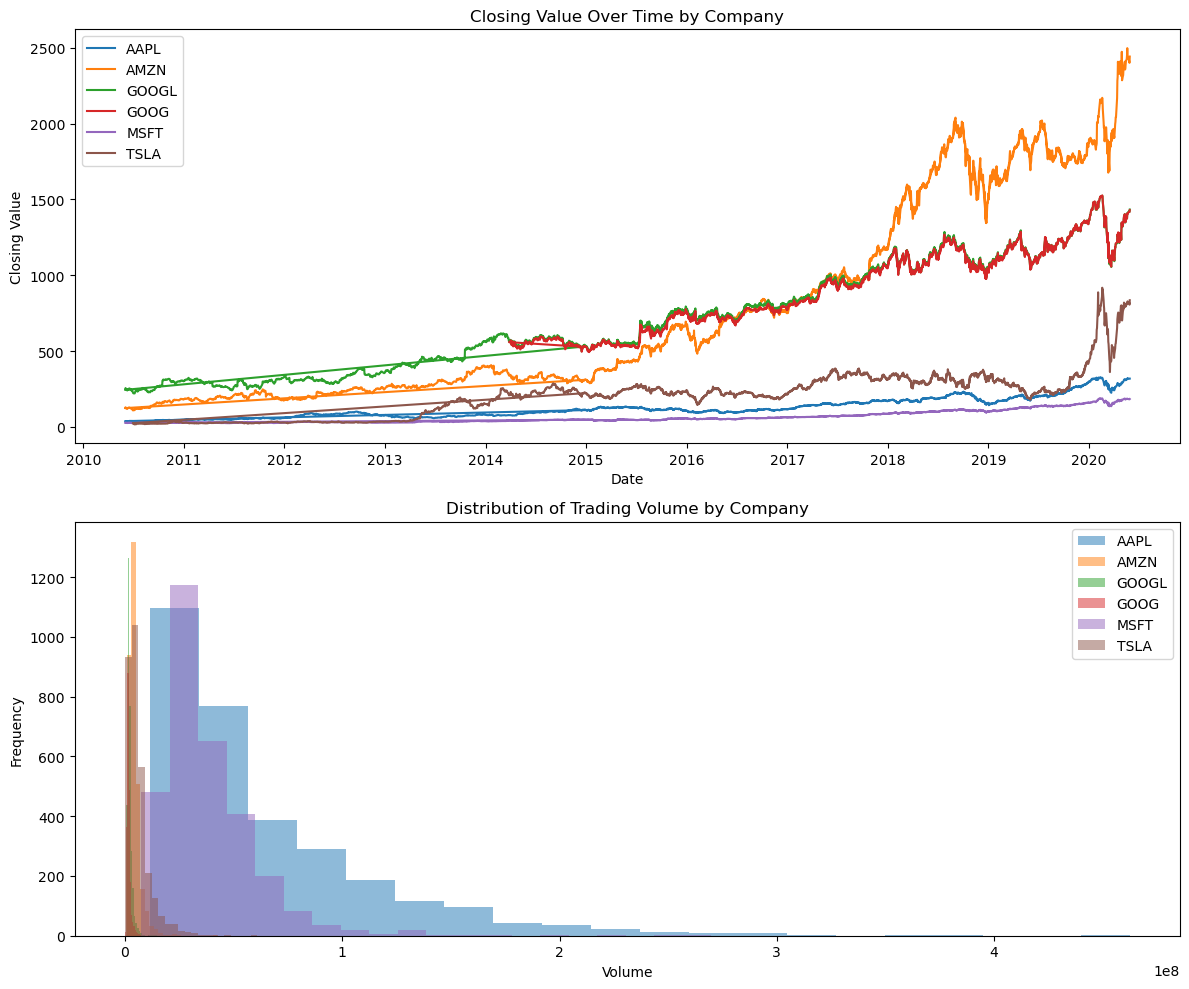

In [20]:
# Setting up the figure and axis
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# Plotting the closing values over time for each company
for ticker in stock_df['ticker_symbol'].unique():
    subset = stock_df[stock_df['ticker_symbol'] == ticker]
    ax[0].plot(pd.to_datetime(subset['day_date']), subset['close_value'], label=ticker)

ax[0].set_title('Closing Value Over Time by Company')
ax[0].set_xlabel('Date')
ax[0].set_ylabel('Closing Value')
ax[0].legend()

# Displaying the distribution of trading volume for each company
for ticker in stock_df['ticker_symbol'].unique():
    subset = stock_df[stock_df['ticker_symbol'] == ticker]
    ax[1].hist(subset['volume'], bins=20, alpha=0.5, label=ticker)

ax[1].set_title('Distribution of Trading Volume by Company')
ax[1].set_xlabel('Volume')
ax[1].set_ylabel('Frequency')
ax[1].legend()

plt.tight_layout()
plt.show()

In [21]:
stock_df = stock_df[(stock_df['day_date'] >= start_day) & (stock_df['day_date'] <= end_day)]

stock_df = stock_df.sort_values(by="day_date")

stock_df

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
2517,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.210
10810,GOOG,2015-01-01,526.40,1367110,531.25,532.60,525.800
8687,GOOGL,2015-01-01,530.66,1235889,537.74,538.40,530.200
16960,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.250
5602,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.010
...,...,...,...,...,...,...,...
11481,MSFT,2019-12-31,157.70,18393380,156.77,157.77,156.450
9358,GOOG,2019-12-31,1337.02,962468,1330.11,1338.00,1329.085
6273,GOOGL,2019-12-31,1339.39,976061,1335.79,1340.66,1332.130
3188,AMZN,2019-12-31,1847.84,2510380,1842.00,1853.26,1832.230


Univariate Analysis

In [22]:
tweet_df["total_engangement"] = tweet_df["comment_num"] + tweet_df["retweet_num"] + tweet_df["like_num"]

In [23]:
tweet_df

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,day_date,total_engangement
0,550803612197457920,AAPL,SentiQuant,2015-01-01 23:59:49,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01,1
2541340,550503763635896320,AMZN,itassessors,2015-01-01 04:08:19,Jeff Bezos lost $7.4 billion in Amazon's worst...,0,0,0,2015-01-01,0
2541339,550503749085454336,AMZN,gautamkamath,2015-01-01 04:08:16,Beginning of the end? @WSJ: Jeff Bezos lost $7...,0,0,0,2015-01-01,0
2541338,550502180466491392,AMZN,newscaster,2015-01-01 04:02:02,"That's with a ""B"". @WSJ: Jeff Bezos lost $7.4 ...",0,0,0,2015-01-01,0
2541337,550501951067418624,AMZN,oh_HOLMES,2015-01-01 04:01:07,Damn! Lol RT @WSJ: Jeff Bezos lost $7.4 billio...,0,0,0,2015-01-01,0
...,...,...,...,...,...,...,...,...,...,...
1863080,1211870023221948416,AAPL,BravoTrader,2019-12-31 04:41:43,$AAPL #Apple led the pack in #AI acquisitions ...,0,0,0,2019-12-31,0
1863079,1211869139976912896,TSLA,jberger574,2019-12-31 04:38:13,Great winning plans on $TSLA and $AAPL from sa...,0,0,0,2019-12-31,0
1863078,1211869139976912896,AAPL,jberger574,2019-12-31 04:38:13,Great winning plans on $TSLA and $AAPL from sa...,0,0,0,2019-12-31,0
1863089,1211872107627286528,AAPL,tribepublic,2019-12-31 04:50:00,Vista Partners Daily Market Recap For December...,0,2,3,2019-12-31,5


In [24]:
import pandas as pd
from scipy.stats import chi2_contingency



# Create a contingency table using pandas crosstab
contingency_table = pd.crosstab(tweet_df['ticker_symbol'], tweet_df['body'])

# Perform the Chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Print the results
print(f"Chi-Squared Statistic: {chi2}")
print(f"P-value: {p}")
print(f"Degrees of Freedom: {dof}")
print("Expected Frequencies:")
print(expected)

Chi-Squared Statistic: 17024790.56930538
P-value: 0.0
Degrees of Freedom: 16630965
Expected Frequencies:
[[0.32861318 0.32861318 0.32861318 ... 0.32861318 0.32861318 0.32861318]
 [0.16573829 0.16573829 0.16573829 ... 0.16573829 0.16573829 0.16573829]
 [0.09052784 0.09052784 0.09052784 ... 0.09052784 0.09052784 0.09052784]
 [0.0755386  0.0755386  0.0755386  ... 0.0755386  0.0755386  0.0755386 ]
 [0.08664032 0.08664032 0.08664032 ... 0.08664032 0.08664032 0.08664032]
 [0.25294175 0.25294175 0.25294175 ... 0.25294175 0.25294175 0.25294175]]


count    4.336445e+06
mean     3.030775e+00
std      1.901432e+01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.703000e+03
Name: total_engangement, dtype: float64


/tmp/ipykernel_20/565443539.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df[column_name], color='g', bins=bins, hist_kws={'alpha': 0.4});


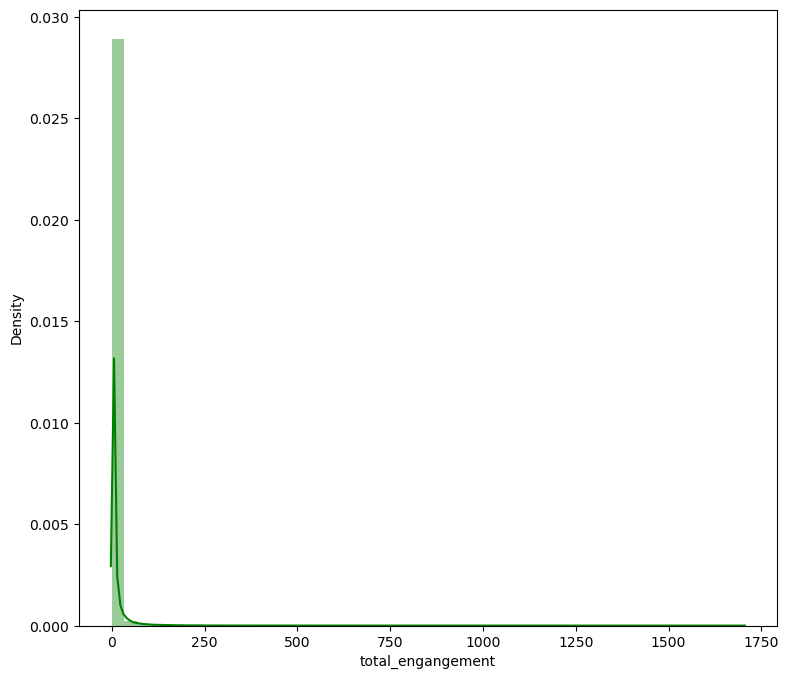

In [25]:
def column_distplot(df, column_name, bins=50, describe=True):
    if describe:
        print(df[column_name].describe())
    plt.figure(figsize=(9, 8))
    sns.distplot(df[column_name], color='g', bins=bins, hist_kws={'alpha': 0.4});
    
column_distplot(tweet_df, column_name="total_engangement")    
    

In [26]:
tweet_df

,tweet_id,ticker_symbol,writer,post_date,body,comment_num,retweet_num,like_num,day_date,total_engangement
0,550803612197457920,AAPL,SentiQuant,2015-01-01 23:59:49,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,0,0,1,2015-01-01,1
2541340,550503763635896320,AMZN,itassessors,2015-01-01 04:08:19,Jeff Bezos lost $7.4 billion in Amazon's worst...,0,0,0,2015-01-01,0
2541339,550503749085454336,AMZN,gautamkamath,2015-01-01 04:08:16,Beginning of the end? @WSJ: Jeff Bezos lost $7...,0,0,0,2015-01-01,0
2541338,550502180466491392,AMZN,newscaster,2015-01-01 04:02:02,"That's with a ""B"". @WSJ: Jeff Bezos lost $7.4 ...",0,0,0,2015-01-01,0
2541337,550501951067418624,AMZN,oh_HOLMES,2015-01-01 04:01:07,Damn! Lol RT @WSJ: Jeff Bezos lost $7.4 billio...,0,0,0,2015-01-01,0
...,...,...,...,...,...,...,...,...,...,...
1863080,1211870023221948416,AAPL,BravoTrader,2019-12-31 04:41:43,$AAPL #Apple led the pack in #AI acquisitions ...,0,0,0,2019-12-31,0
1863079,1211869139976912896,TSLA,jberger574,2019-12-31 04:38:13,Great winning plans on $TSLA and $AAPL from sa...,0,0,0,2019-12-31,0
1863078,1211869139976912896,AAPL,jberger574,2019-12-31 04:38:13,Great winning plans on $TSLA and $AAPL from sa...,0,0,0,2019-12-31,0
1863089,1211872107627286528,AAPL,tribepublic,2019-12-31 04:50:00,Vista Partners Daily Market Recap For December...,0,2,3,2019-12-31,5


In [27]:
tweet_df.drop(['tweet_id','writer','post_date','comment_num','retweet_num','like_num'],axis=1,inplace=True)

In [28]:
# Grouping the data by the "ticker_symbol" column and counting the number of tweets for each stock
tweet_count_by_stock = tweet_df['ticker_symbol'].value_counts()

# Previewing the counts for each ticker symbol
tweet_count_by_stock.head()

AAPL    1425013
TSLA    1096868
AMZN     718715
GOOG     392569
MSFT     375711
Name: ticker_symbol, dtype: int64

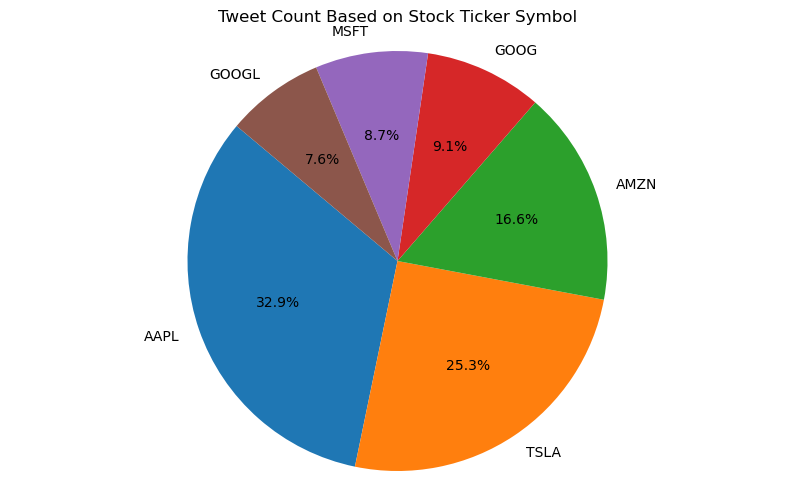

In [29]:
# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(tweet_count_by_stock, labels=tweet_count_by_stock.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Tweet Count Based on Stock Ticker Symbol')
plt.show()


Text Analysis 

In [30]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r'@[A-Za-z0-9]+', '', tweet)
    tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
    words = word_tokenize(tweet)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    
    #lemmatizer = WordNetLemmatizer()
    #lemmatized_words = [lemmatizer.lemmatize(word) for word in filtered_words]
    
    cleaned_tweet = ' '.join(filtered_words)
    return cleaned_tweet

# Apply the cleaning function to the 'tweets' column
tweet_df['cleaned_tweets'] = tweet_df['body'].apply(clean_tweet)

# Print the original DataFrame and the cleaned DataFrame
print("Original DataFrame:")
print(tweet_df[['body']])
print("\nCleaned DataFrame:")
print(tweet_df[['cleaned_tweets']])


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Original DataFrame:
                                                      body
0        #TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...
2541340  Jeff Bezos lost $7.4 billion in Amazon's worst...
2541339  Beginning of the end? @WSJ: Jeff Bezos lost $7...
2541338  That's with a "B". @WSJ: Jeff Bezos lost $7.4 ...
2541337  Damn! Lol RT @WSJ: Jeff Bezos lost $7.4 billio...
...                                                    ...
1863080  $AAPL #Apple led the pack in #AI acquisitions ...
1863079  Great winning plans on $TSLA and $AAPL from sa...
1863078  Great winning plans on $TSLA and $AAPL from sa...
1863089  Vista Partners Daily 

In [31]:
tweet_df.head(8)

,ticker_symbol,body,day_date,total_engangement,cleaned_tweets
0,AAPL,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,2015-01-01,1,toptickertweets aapl imrs baba ebay amzn ign s...
2541340,AMZN,Jeff Bezos lost $7.4 billion in Amazon's worst...,2015-01-01,0,jeff bezos lost billion amazons worst year sin...
2541339,AMZN,Beginning of the end? @WSJ: Jeff Bezos lost $7...,2015-01-01,0,beginning end jeff bezos lost billion amazons ...
2541338,AMZN,"That's with a ""B"". @WSJ: Jeff Bezos lost $7.4 ...",2015-01-01,0,thats b jeff bezos lost billion amazons worst ...
2541337,AMZN,Damn! Lol RT @WSJ: Jeff Bezos lost $7.4 billio...,2015-01-01,0,damn lol rt jeff bezos lost billion amazons wo...
2541336,AMZN,"""@WSJ: Jeff Bezos lost $7.4 billion in Amazon'...",2015-01-01,0,jeff bezos lost billion amazons worst year sin...
2541335,AMZN,"RT ""@WSJ: Jeff Bezos lost $7.4 billion in Ama...",2015-01-01,0,rt jeff bezos lost billion amazons worst year ...
2541334,AMZN,WSJ:Jeff Bezos lost $7.4 billion in Amazon's w...,2015-01-01,0,wsjjeff bezos lost billion amazons worst year ...


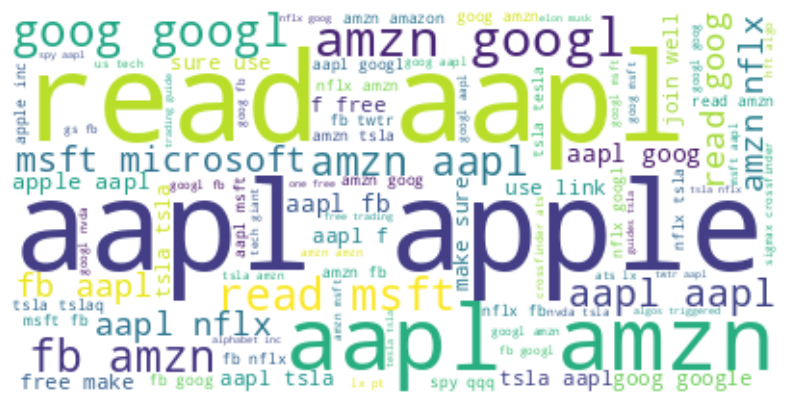

In [32]:
# Generate the word cloud
text = ' '.join(tweet_df['cleaned_tweets'])
wordcloud = WordCloud(background_color='white').generate(text)

# Display the generated word cloud image
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [33]:
# Initialize the Afinn lexicon
afinn = Afinn()
tweet_df['afinn_score'] = tweet_df['cleaned_tweets'].apply(lambda tweet: afinn.score(tweet))
tweet_df['afinn_score'].sample(5)

def lexicon_sentiment(text):
    words = text.split()
    sentiment_scores = [afinn.score(word) for word in words]
    
    # Calculate the overall sentiment of the text
    overall_sentiment = sum(sentiment_scores)
    
    if overall_sentiment > 0:
        sentiment_label = 'positive'
    elif overall_sentiment < 0:
        sentiment_label = 'negative'
    else:
        sentiment_label = 'neutral'
    
    return sentiment_label
# Initialize the SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def getVanderScore(text):
    sentiment_scores = sia.polarity_scores(text)
    return sentiment_scores['compound']  # Return the compound sentiment score

# Apply getVanderScore function to the 'body' column
tweet_df['vader_score'] = tweet_df['body'].apply(lambda tweet: getVanderScore(tweet))


# Apply lexicon_sentiment function to the 'tweets' column
tweet_df['sentiment'] = tweet_df['cleaned_tweets'].apply(lexicon_sentiment)

# Print the original DataFrame with sentiment labels
print(tweet_df)


        ticker_symbol                                               body  \
0                AAPL  #TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...   
2541340          AMZN  Jeff Bezos lost $7.4 billion in Amazon's worst...   
2541339          AMZN  Beginning of the end? @WSJ: Jeff Bezos lost $7...   
2541338          AMZN  That's with a "B". @WSJ: Jeff Bezos lost $7.4 ...   
2541337          AMZN  Damn! Lol RT @WSJ: Jeff Bezos lost $7.4 billio...   
...               ...                                                ...   
1863080          AAPL  $AAPL #Apple led the pack in #AI acquisitions ...   
1863079          TSLA  Great winning plans on $TSLA and $AAPL from sa...   
1863078          AAPL  Great winning plans on $TSLA and $AAPL from sa...   
1863089          AAPL  Vista Partners Daily Market Recap For December...   
4336444          TSLA  Patiently Waiting for the no twitter sitter tw...   

          day_date  total_engangement  \
0       2015-01-01                  1   
25413

In [34]:
tweet_df1=tweet_df

In [35]:
tweet_df1.head(50)

,ticker_symbol,body,day_date,total_engangement,cleaned_tweets,afinn_score,vader_score,sentiment
0,AAPL,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,2015-01-01,1,toptickertweets aapl imrs baba ebay amzn ign s...,0.0,0.0000,neutral
2541340,AMZN,Jeff Bezos lost $7.4 billion in Amazon's worst...,2015-01-01,0,jeff bezos lost billion amazons worst year sin...,-6.0,-0.7506,negative
2541339,AMZN,Beginning of the end? @WSJ: Jeff Bezos lost $7...,2015-01-01,0,beginning end jeff bezos lost billion amazons ...,-6.0,-0.7506,negative
2541338,AMZN,"That's with a ""B"". @WSJ: Jeff Bezos lost $7.4 ...",2015-01-01,0,thats b jeff bezos lost billion amazons worst ...,-6.0,-0.7506,negative
2541337,AMZN,Damn! Lol RT @WSJ: Jeff Bezos lost $7.4 billio...,2015-01-01,0,damn lol rt jeff bezos lost billion amazons wo...,-5.0,-0.7644,negative
2541336,AMZN,"""@WSJ: Jeff Bezos lost $7.4 billion in Amazon'...",2015-01-01,0,jeff bezos lost billion amazons worst year sin...,-6.0,-0.7506,negative
2541335,AMZN,"RT ""@WSJ: Jeff Bezos lost $7.4 billion in Ama...",2015-01-01,0,rt jeff bezos lost billion amazons worst year ...,-6.0,-0.7506,negative
2541334,AMZN,WSJ:Jeff Bezos lost $7.4 billion in Amazon's w...,2015-01-01,0,wsjjeff bezos lost billion amazons worst year ...,-6.0,-0.7506,negative
2541333,AMZN,“@WSJ: Jeff Bezos lost $7.4 billion in Amazon'...,2015-01-01,0,jeff bezos lost billion amazons worst year sin...,-4.0,-0.5423,negative
2541332,AMZN,One of the many reasons I hate Amazon. RT @WSJ...,2015-01-01,0,one many reasons hate amazon rt jeff bezos los...,-9.0,-0.8555,negative


In [36]:
tweet_df1.head()

,ticker_symbol,body,day_date,total_engangement,cleaned_tweets,afinn_score,vader_score,sentiment
0,AAPL,#TOPTICKERTWEETS $AAPL $IMRS $BABA $EBAY $AMZN...,2015-01-01,1,toptickertweets aapl imrs baba ebay amzn ign s...,0.0,0.0000,neutral
2541340,AMZN,Jeff Bezos lost $7.4 billion in Amazon's worst...,2015-01-01,0,jeff bezos lost billion amazons worst year sin...,-6.0,-0.7506,negative
2541339,AMZN,Beginning of the end? @WSJ: Jeff Bezos lost $7...,2015-01-01,0,beginning end jeff bezos lost billion amazons ...,-6.0,-0.7506,negative
2541338,AMZN,"That's with a ""B"". @WSJ: Jeff Bezos lost $7.4 ...",2015-01-01,0,thats b jeff bezos lost billion amazons worst ...,-6.0,-0.7506,negative
2541337,AMZN,Damn! Lol RT @WSJ: Jeff Bezos lost $7.4 billio...,2015-01-01,0,damn lol rt jeff bezos lost billion amazons wo...,-5.0,-0.7644,negative


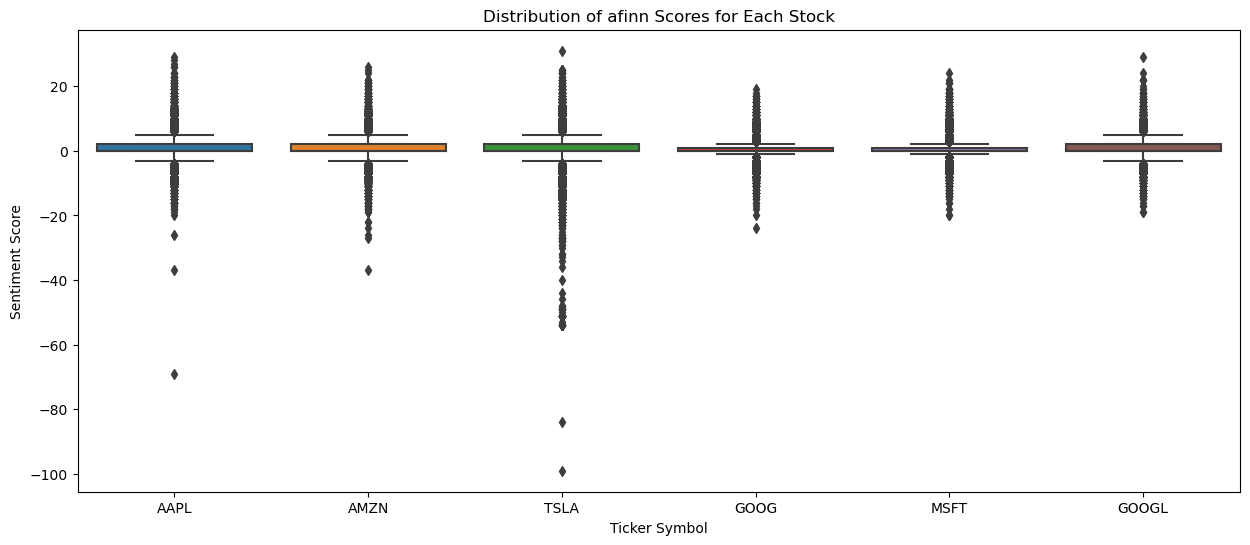

In [37]:


plt.figure(figsize=(15, 6))
sns.boxplot(x='ticker_symbol', y='afinn_score', data=tweet_df1)

plt.title('Distribution of afinn Scores for Each Stock')
plt.xlabel('Ticker Symbol')
plt.ylabel('Sentiment Score')
plt.show()


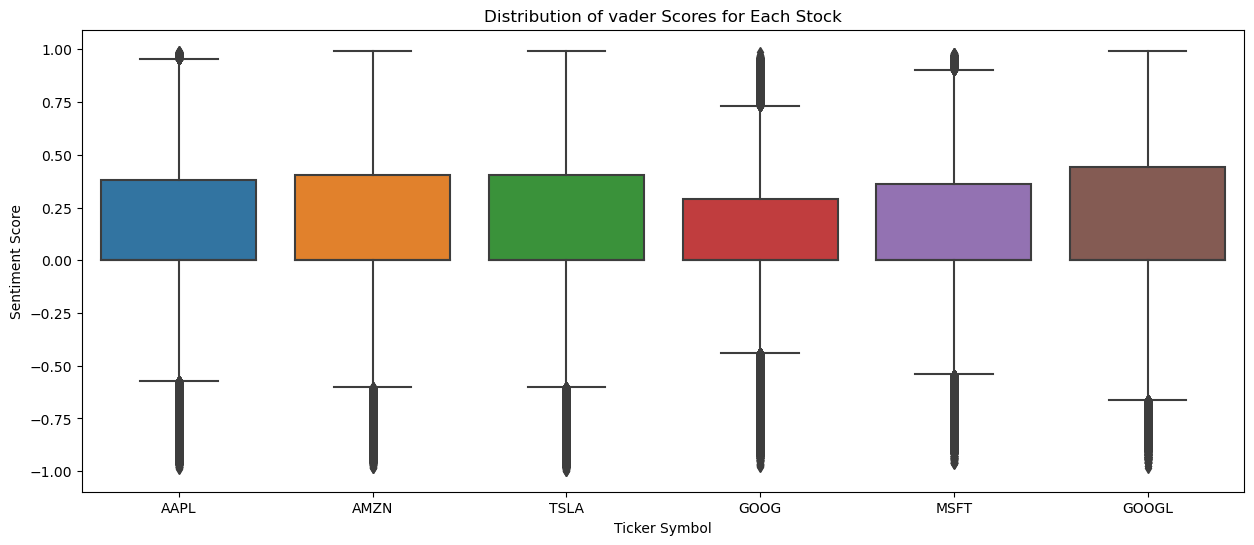

In [38]:
plt.figure(figsize=(15, 6))
sns.boxplot(x='ticker_symbol', y='vader_score', data=tweet_df1)

plt.title('Distribution of vader Scores for Each Stock')
plt.xlabel('Ticker Symbol')
plt.ylabel('Sentiment Score')
plt.show()

In [39]:
vader_ticker=tweet_df1.groupby('day_date')['ticker_symbol'].value_counts()
average_vader= tweet_df1.groupby('day_date')['vader_score'].mean()
average_afinn= tweet_df1.groupby('day_date')['afinn_score'].mean()
volume=tweet_df1['day_date'].value_counts()

volume=pd.DataFrame(volume)
volume = volume.reset_index().rename(columns={'index': 'timestamp'})
i = 1
column_name = volume.columns[i]
volume.rename(columns={column_name: 'volume'}, inplace=True)
i = 0
column_name = volume.columns[i]
volume.rename(columns={column_name: 'day_date'}, inplace=True)
vader_ticker.head(50)

day_date    ticker_symbol
2015-01-01  AAPL              299
            AMZN              131
            TSLA               99
            GOOG               60
            MSFT               54
            GOOGL              45
2015-01-02  AAPL              867
            TSLA              201
            AMZN              174
            GOOG              145
            GOOGL             111
            MSFT              107
2015-01-03  AAPL              346
            GOOG              158
            GOOGL             140
            TSLA               96
            AMZN               67
            MSFT               59
2015-01-04  AAPL              406
            GOOG              212
            GOOGL             140
            TSLA              114
            AMZN               85
            MSFT               34
2015-01-05  AAPL             1147
            GOOG              299
            AMZN              281
            TSLA              278
            GOOGL     

In [40]:
def compute_category_means(df, date_col, category_col, numerical_col):
    
    return df.groupby([date_col, category_col])[numerical_col].mean().reset_index()


result = compute_category_means(tweet_df1, 'day_date', 'ticker_symbol', 'vader_score')
result2 = compute_category_means(tweet_df1, 'day_date', 'ticker_symbol', 'afinn_score')

final_merge=result.merge(result2, left_index=True, right_index=True)

final_merge=final_merge.drop(columns=['day_date_y','ticker_symbol_y'])
i = 0
column_name = final_merge.columns[i]
final_merge.rename(columns={column_name: 'day_date'}, inplace=True)
i = 1
column_name = final_merge.columns[i]
final_merge.rename(columns={column_name: 'ticker_symbol'}, inplace=True)

final_merge.head(50)


,day_date,ticker_symbol,vader_score,afinn_score
0,2015-01-01,AAPL,0.145556,0.635452
1,2015-01-01,AMZN,-0.159267,-1.839695
2,2015-01-01,GOOG,0.184912,0.933333
3,2015-01-01,GOOGL,0.189336,1.377778
4,2015-01-01,MSFT,0.121148,0.462963
5,2015-01-01,TSLA,0.138119,0.333333
6,2015-01-02,AAPL,0.088134,0.416378
7,2015-01-02,AMZN,0.109813,0.275862
8,2015-01-02,GOOG,0.152546,0.668966
9,2015-01-02,GOOGL,0.139932,0.648649


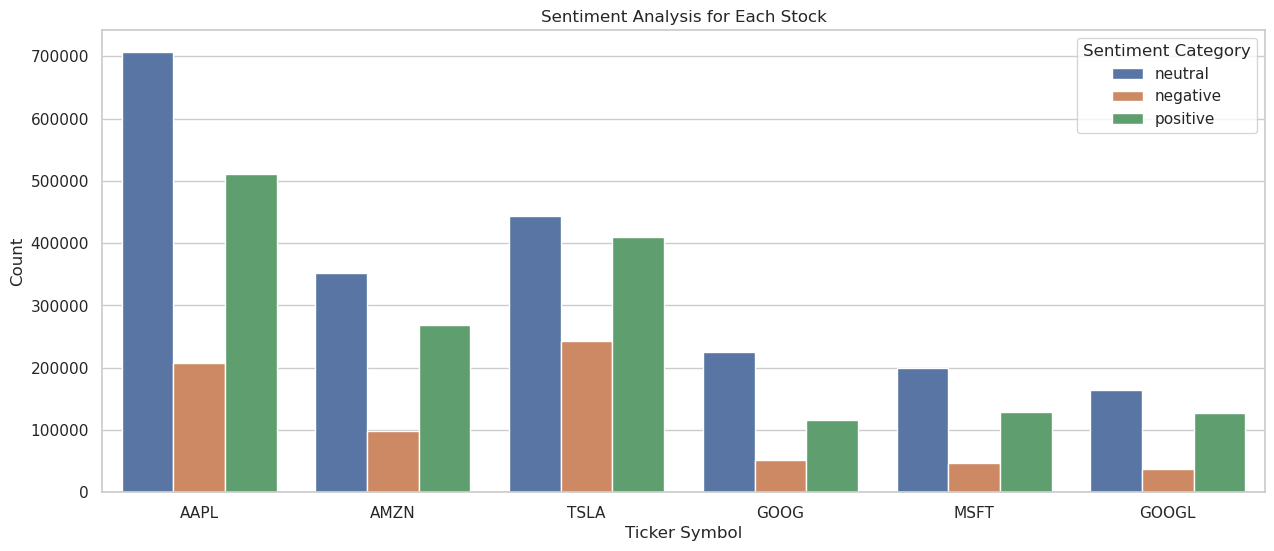

In [41]:
# Set the style of the visualization
sns.set(style="whitegrid")

# Create a bar plot showing the count of each sentiment category for each ticker symbol
plt.figure(figsize=(15, 6))
sns.countplot(x='ticker_symbol', hue='sentiment', data=tweet_df1)

plt.title('Sentiment Analysis for Each Stock')
plt.xlabel('Ticker Symbol')
plt.ylabel('Count')
plt.legend(title='Sentiment Category')
plt.show()


In [42]:
consolidated_df = final_merge.set_index(['day_date', 'ticker_symbol'])[['vader_score', 'afinn_score']]
consolidated_df.head(10)

vader_score  afinn_score
day_date   ticker_symbol                          
2015-01-01 AAPL              0.145556     0.635452
           AMZN             -0.159267    -1.839695
           GOOG              0.184912     0.933333
           GOOGL             0.189336     1.377778
           MSFT              0.121148     0.462963
           TSLA              0.138119     0.333333
2015-01-02 AAPL              0.088134     0.416378
           AMZN              0.109813     0.275862
           GOOG              0.152546     0.668966
           GOOGL             0.139932     0.648649

In [43]:
stock_df

,ticker_symbol,day_date,close_value,volume,open_value,high_value,low_value
2517,AAPL,2015-01-01,110.38,41304780,112.82,113.13,110.210
10810,GOOG,2015-01-01,526.40,1367110,531.25,532.60,525.800
8687,GOOGL,2015-01-01,530.66,1235889,537.74,538.40,530.200
16960,TSLA,2015-01-01,222.41,2392947,223.09,225.68,222.250
5602,AMZN,2015-01-01,310.35,2048676,311.55,312.98,310.010
...,...,...,...,...,...,...,...
11481,MSFT,2019-12-31,157.70,18393380,156.77,157.77,156.450
9358,GOOG,2019-12-31,1337.02,962468,1330.11,1338.00,1329.085
6273,GOOGL,2019-12-31,1339.39,976061,1335.79,1340.66,1332.130
3188,AMZN,2019-12-31,1847.84,2510380,1842.00,1853.26,1832.230


In [44]:
#checking
st=stock_df.groupby('day_date')['ticker_symbol'].value_counts()
st.head(40)

day_date    ticker_symbol
2015-01-01  AAPL             1
            AMZN             1
            GOOG             1
            GOOGL            1
            MSFT             1
            TSLA             1
2015-01-02  AAPL             1
            AMZN             1
            GOOG             1
            GOOGL            1
            MSFT             1
            TSLA             1
2015-01-03  AAPL             1
            AMZN             1
            GOOG             1
            GOOGL            1
            MSFT             1
            TSLA             1
2015-01-04  AAPL             1
            AMZN             1
            GOOG             1
            GOOGL            1
            MSFT             1
            TSLA             1
2015-01-05  AAPL             1
            AMZN             1
            GOOG             1
            GOOGL            1
            MSFT             1
            TSLA             1
2015-01-06  AAPL             1
            A

In [45]:
new_merge=pd.merge(consolidated_df,stock_df, on=['day_date', 'ticker_symbol'], how='inner')
new_merge.shape

(10948, 9)

In [46]:
new_merge

,day_date,ticker_symbol,vader_score,afinn_score,close_value,volume,open_value,high_value,low_value
0,2015-01-01,AAPL,0.145556,0.635452,110.38,41304780,112.82,113.13,110.210
1,2015-01-01,AMZN,-0.159267,-1.839695,310.35,2048676,311.55,312.98,310.010
2,2015-01-01,GOOG,0.184912,0.933333,526.40,1367110,531.25,532.60,525.800
3,2015-01-01,GOOGL,0.189336,1.377778,530.66,1235889,537.74,538.40,530.200
4,2015-01-01,MSFT,0.121148,0.462963,46.45,21551090,46.73,47.44,46.450
...,...,...,...,...,...,...,...,...,...
10943,2019-12-31,AMZN,0.207272,1.394515,1847.84,2510380,1842.00,1853.26,1832.230
10944,2019-12-31,GOOG,0.155536,1.526316,1337.02,962468,1330.11,1338.00,1329.085
10945,2019-12-31,GOOGL,0.123122,0.808333,1339.39,976061,1335.79,1340.66,1332.130
10946,2019-12-31,MSFT,0.214171,1.573394,157.70,18393380,156.77,157.77,156.450


In [47]:
stock_df.shape

(10956, 7)

# updated dataset****

In [48]:
stock_df=new_merge#pd.read_csv('/kaggle/input/private11111/stock_saved.csv')

In [49]:
stock_df

,day_date,ticker_symbol,vader_score,afinn_score,close_value,volume,open_value,high_value,low_value
0,2015-01-01,AAPL,0.145556,0.635452,110.38,41304780,112.82,113.13,110.210
1,2015-01-01,AMZN,-0.159267,-1.839695,310.35,2048676,311.55,312.98,310.010
2,2015-01-01,GOOG,0.184912,0.933333,526.40,1367110,531.25,532.60,525.800
3,2015-01-01,GOOGL,0.189336,1.377778,530.66,1235889,537.74,538.40,530.200
4,2015-01-01,MSFT,0.121148,0.462963,46.45,21551090,46.73,47.44,46.450
...,...,...,...,...,...,...,...,...,...
10943,2019-12-31,AMZN,0.207272,1.394515,1847.84,2510380,1842.00,1853.26,1832.230
10944,2019-12-31,GOOG,0.155536,1.526316,1337.02,962468,1330.11,1338.00,1329.085
10945,2019-12-31,GOOGL,0.123122,0.808333,1339.39,976061,1335.79,1340.66,1332.130
10946,2019-12-31,MSFT,0.214171,1.573394,157.70,18393380,156.77,157.77,156.450


In [50]:
stock_df=pd.read_csv('/kaggle/input/stockvalues1111/stock_saved1.csv')

In [51]:
# Save the dataframe as a CSV file
file_path = "stock_saved1.csv"
stock_df.to_csv(file_path, index=False)

In [52]:
def plot_1(model,ticker_symbol):
    # Predicting the close values for the test set
    y_pred = model.predict(X_test)

    # Getting the corresponding dates for the test set
    test_dates = stock_df[stock_df['ticker_symbol'] == ticker_symbol]['day_date'][stock_df['day_date'] >= '2019-08-01']

    # Plotting the actual vs. predicted close values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Actual Close Value')
    plt.plot(test_dates, y_pred, label='Predicted Close Value', linestyle='dashed')
    plt.xlabel('Date')
    plt.ylabel('Close Value')
    plt.title('Actual vs. Predicted Close Value for ' + ticker_symbol)
    plt.legend()
    plt.show()


In [53]:
stock_df.head()

,day_date,ticker_symbol,vader_score,afinn_score,close_value,volume,open_value,high_value,low_value
0,2015-01-01,AAPL,0.145556,0.635452,110.38,41304780,112.82,113.13,110.21
1,2015-01-01,AMZN,-0.159267,-1.839695,310.35,2048676,311.55,312.98,310.01
2,2015-01-01,GOOG,0.184912,0.933333,526.40,1367110,531.25,532.60,525.80
3,2015-01-01,GOOGL,0.189336,1.377778,530.66,1235889,537.74,538.40,530.20
4,2015-01-01,MSFT,0.121148,0.462963,46.45,21551090,46.73,47.44,46.45


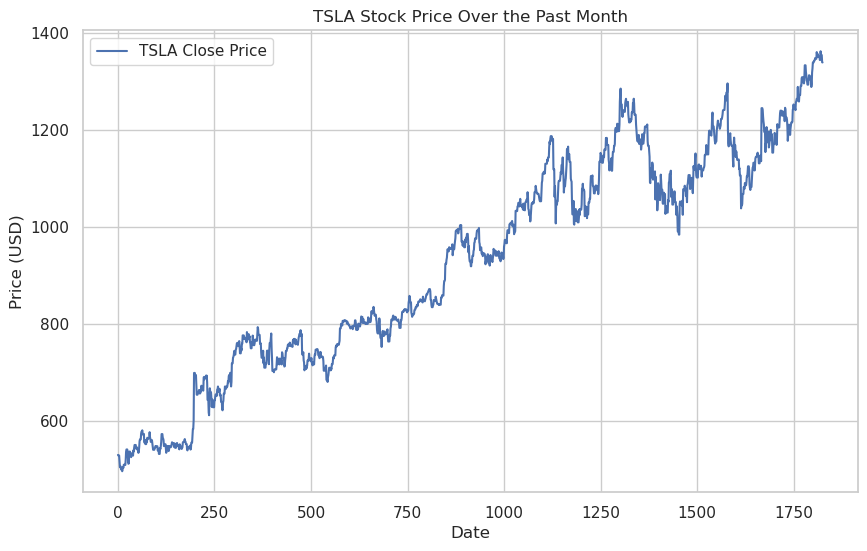

In [54]:
# Plot the line chart
plt.figure(figsize=(10, 6))
aapl_v = stock_df[stock_df['ticker_symbol'] == 'GOOGL'][['day_date', 'close_value']].reset_index(drop=True)

plt.plot(aapl_v['close_value'], label='TSLA Close Price')
plt.title('TSLA Stock Price Over the Past Month')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [55]:
def plot_1(model, ticker_symbol):
    # Predicting the close values for the test set
    y_pred = model.predict(X_test)

    # Getting the corresponding dates for the test set
    test_dates = stock_df[stock_df['ticker_symbol'] == ticker_symbol]['day_date'][stock_df['day_date'] >= '2019-08-01']
    test_dates = pd.to_datetime(test_dates)

    # Plotting the actual vs. predicted close values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Actual Close Value')
    plt.plot(test_dates, y_pred, label='Predicted Close Value', linestyle='dashed')

    # Customizing the x-axis labels to show the first day of each month
    plt.xticks(pd.date_range(start=test_dates.min(), end=test_dates.max(), freq='MS'), rotation=45)
    
    plt.xlabel('Date')
    plt.ylabel('Close Value')
    plt.title('Actual vs. Predicted Close Value for ' + ticker_symbol)
    plt.legend()
    plt.show()


****# *Scaling the dataset*

In [56]:

def preprocess_data(data, ticker_symbol):
    # Filter the data based on the given ticker symbol
    data_filtered = data[data['ticker_symbol'] == ticker_symbol]

    # Split the data based on the specified date range
    train_data = data_filtered[data_filtered['day_date'] < '2019-07-30']
    test_data = data_filtered[data_filtered['day_date'] >= '2019-08-01']

    # Separate features and target variable
    X_train = train_data.drop(columns=['day_date', 'ticker_symbol', 'close_value'])
    y_train = train_data['close_value']
    X_test = test_data.drop(columns=['day_date', 'ticker_symbol', 'close_value'])
    y_test = test_data['close_value']

    # Normalize the features
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)

    return X_train_normalized, y_train, X_test_normalized, y_test

# Example: Preprocessing data for the ticker symbol "AAPL"
ticker_symbol = 'GOOGL'
X_train, y_train, X_test, y_test = preprocess_data(stock_df, ticker_symbol)

# Displaying the shapes of the processed data
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((1671, 6), (1671,), (153, 6), (153,))

In [57]:
# Importing necessary libraries


# Defining the ANN model
def create_ann_model(input_shape):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_shape,)))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Single output node for regression
    model.compile(optimizer='adam', loss='mse')
    return model

# Creating the ANN model for the given input shape
ann_model = create_ann_model(X_train.shape[1])

# Training the ANN model
history = ann_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Evaluating the model on the test data
test_loss = ann_model.evaluate(X_test, y_test, verbose=0)

# Returning the test loss (Mean Squared Error)
test_loss
y_pred = ann_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

5/5 [==============================] - 0s 2ms/step


1521.2453150459642

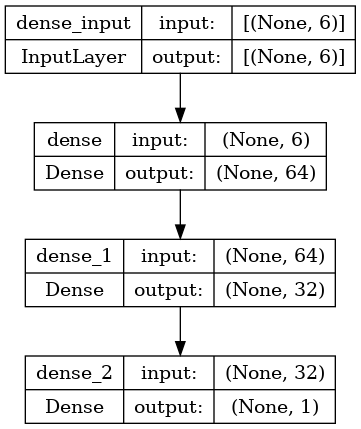

In [58]:
from keras.utils import plot_model

# Plot the model
plot_model(ann_model, to_file='ann structure.png', show_shapes=True, show_layer_names=True)

In [59]:
test_dates = stock_df[stock_df['ticker_symbol'] == ticker_symbol]['day_date'][stock_df['day_date'] >= '2019-08-01']

In [60]:
def rolling_averages(y_test,model):
    y_pred = model.predict(X_test)
# Convert the test dates and values into a Pandas Series
    actual_series = pd.Series(y_test.values, index=pd.to_datetime(test_dates))
    predicted_series = pd.Series(y_pred.flatten(), index=pd.to_datetime(test_dates))

    # Compute the rolling 7-day average
    actual_rolling_avg = actual_series.rolling(window=7).mean()
    predicted_rolling_avg = predicted_series.rolling(window=7).mean()

    # Plot the rolling averages
    plt.figure(figsize=(12, 6))
    plt.plot(actual_rolling_avg, label='Actual Close Value (7-day avg)')
    plt.plot(predicted_rolling_avg, label='Predicted Close Value (7-day avg)', linestyle='dashed')
    
    plt.xlabel('Date')
    plt.ylabel('Close Value')
    plt.title('Actual vs. Predicted Close Value (7-day avg) for ' + ticker_symbol)
    plt.legend()
    plt.show()


5/5 [==============================] - 0s 2ms/step


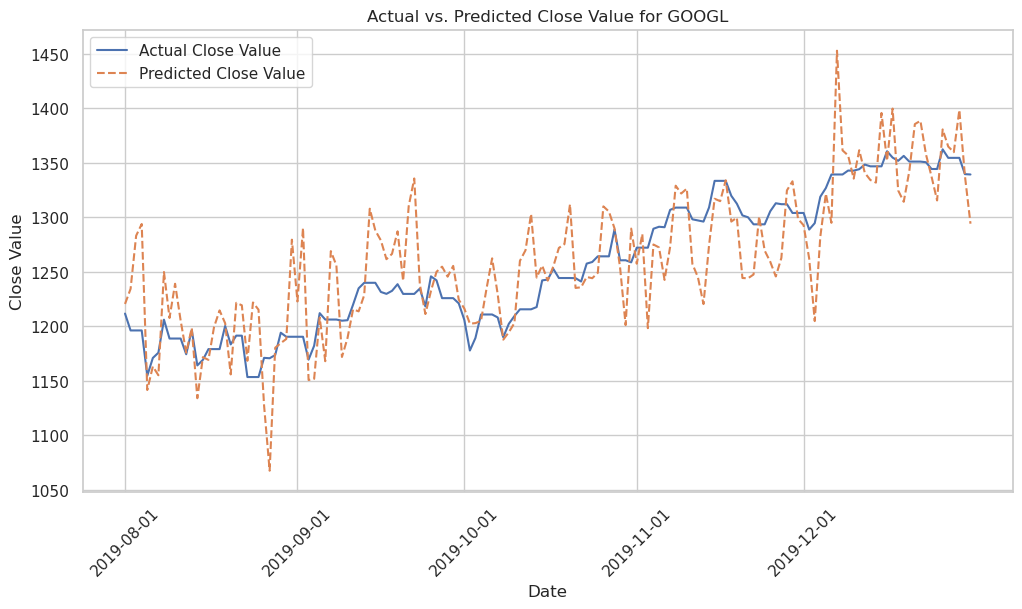

In [61]:
plot_1(ann_model,ticker_symbol)

5/5 [==============================] - 0s 3ms/step


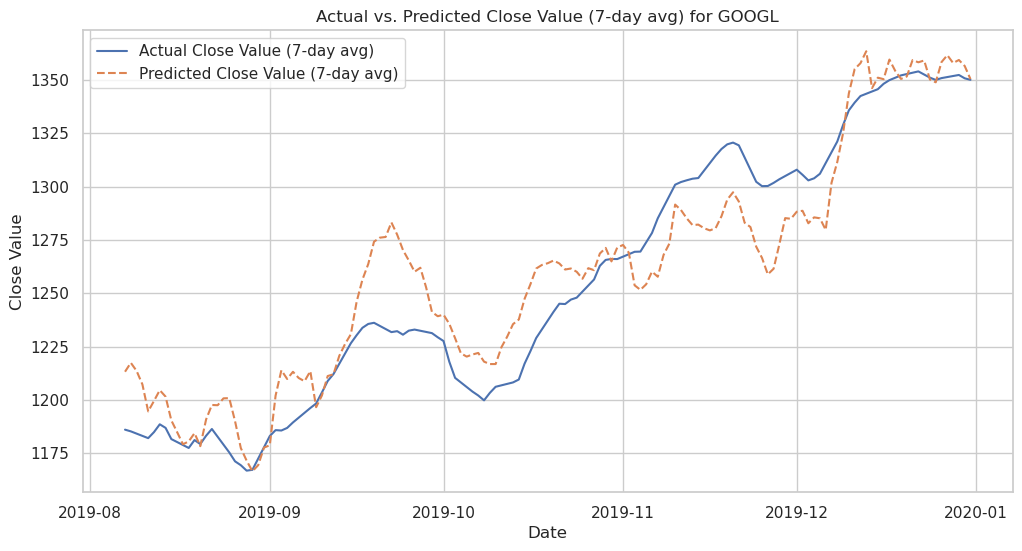

In [62]:
rolling_averages(y_test,ann_model)

In [63]:
def preprocess_data(data, ticker_symbol):
    # Filter the data based on the given ticker symbol
    data_filtered = data[data['ticker_symbol'] == ticker_symbol]

    # Split the data based on the specified date range
    train_data = data_filtered[data_filtered['day_date'] < '2019-07-30']
    test_data = data_filtered[data_filtered['day_date'] >= '2019-08-01']

    # Separate features and target variable
    X_train = train_data.drop(columns=['day_date', 'ticker_symbol', 'close_value'])
    y_train = train_data['close_value']
    X_test = test_data.drop(columns=['day_date', 'ticker_symbol', 'close_value'])
    y_test = test_data['close_value']

    # Normalize the features
    scaler = MinMaxScaler()
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized.reshape(-1, 1, 6), y_train, X_test_normalized.reshape(-1, 1, 6), y_test

X_train, y_train, X_test, y_test = preprocess_data(stock_df, ticker_symbol)

# Define and create LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, activation='relu', input_shape=input_shape))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

lstm_model = create_lstm_model((1, 6))

# Train the model
lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Predict and plot
y_pred = lstm_model.predict(X_test)


mse = mean_squared_error(y_test, y_pred)
mse

5/5 [==============================] - 0s 2ms/step


1636.538836652731

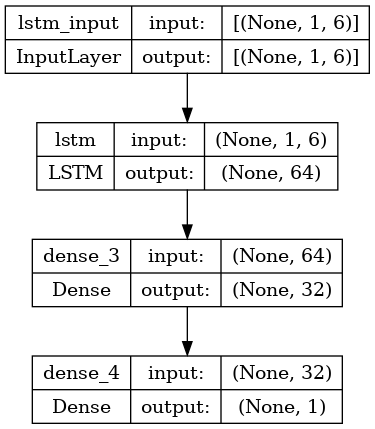

In [64]:
plot_model(lstm_model, to_file='ann structure.png', show_shapes=True, show_layer_names=True)

5/5 [==============================] - 0s 2ms/step


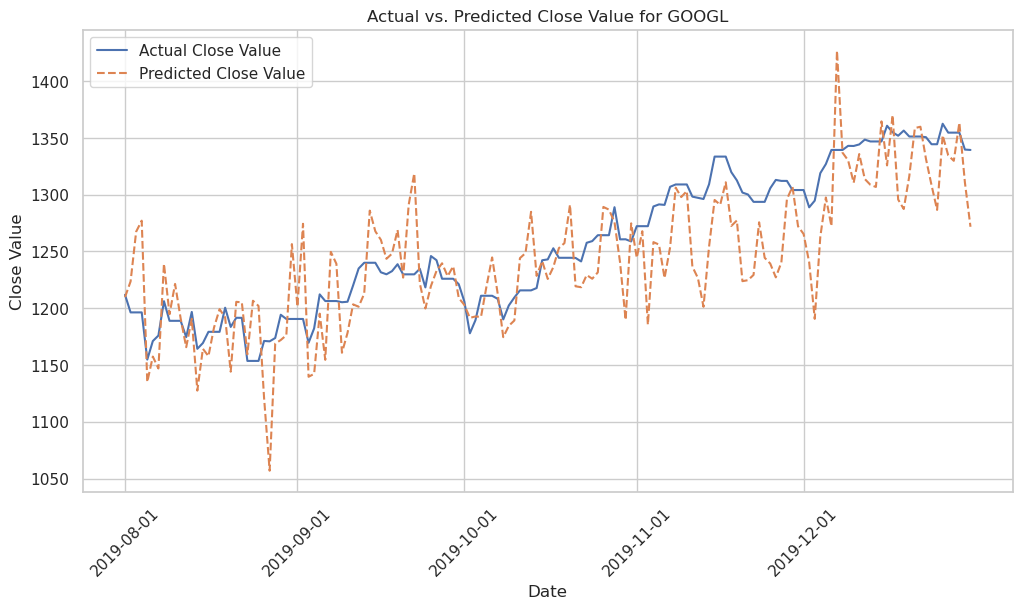

In [65]:

plot_1(lstm_model,ticker_symbol)

5/5 [==============================] - 0s 2ms/step


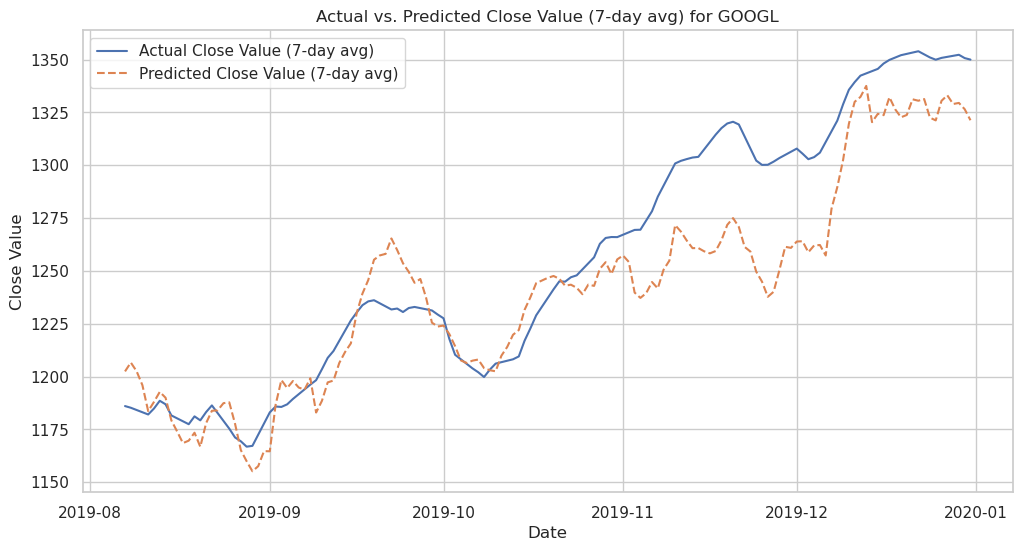

In [66]:
rolling_averages(y_test,lstm_model)

In [67]:
def preprocess_data_arima(ticker_symbol):
    # Filter data based on the given ticker symbol
    data_filtered = stock_df[stock_df['ticker_symbol'] == ticker_symbol]

    # Extract the close values
    close_values = data_filtered['close_value']

    # Split the data based on the specified date range
    train_data = close_values[data_filtered['day_date'] < '2019-08-01']
    test_data = close_values[data_filtered['day_date'] >= '2019-08-01']

    return train_data, test_data


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


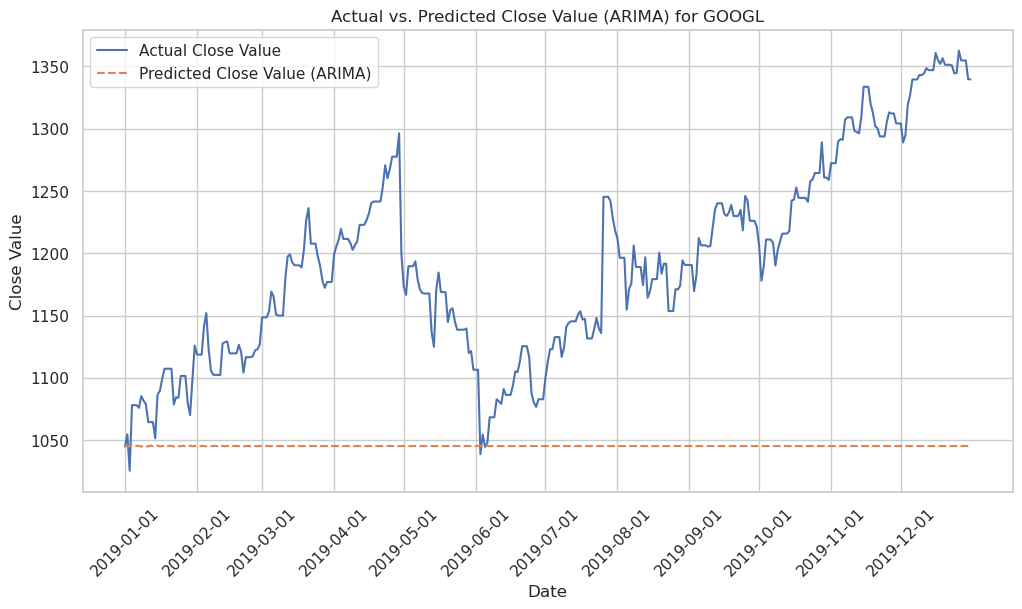

In [68]:
def train_and_plot_arima(ticker_symbol, stock_df):
    # Preprocessing the data for the given ticker symbol
    data = stock_df[stock_df['ticker_symbol'] == ticker_symbol]
    train_data = data['close_value'][data['day_date'] < '2019-01-01']
    test_data = data['close_value'][data['day_date'] >= '2019-01-01']
    test_dates = pd.to_datetime(data['day_date'][data['day_date'] >= '2019-01-01'])

    # Using auto_arima to find the best ARIMA model
    arima_model = auto_arima(train_data, seasonal=False, error_action='ignore', suppress_warnings=True)

    # Fitting the best ARIMA model
    arima_model.fit(train_data)

    # Making predictions
    y_pred = arima_model.predict(n_periods=len(test_data))

    # Plotting the actual vs. predicted close values
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, test_data, label='Actual Close Value')
    plt.plot(test_dates, y_pred, label='Predicted Close Value (ARIMA)', linestyle='dashed')

    # Customizing the x-axis labels to show the first day of each month
    plt.xticks(pd.date_range(start=test_dates.min(), end=test_dates.max(), freq='MS'), rotation=45)

    plt.xlabel('Date')
    plt.ylabel('Close Value')
    plt.title('Actual vs. Predicted Close Value (ARIMA) for ' + ticker_symbol)
    plt.legend()
    plt.show()

# Example usage:
train_and_plot_arima(ticker_symbol, stock_df)


In [69]:
mse = mean_squared_error(y_test, y_pred)
mse

1636.538836652731

<Figure size 1200x600 with 0 Axes>

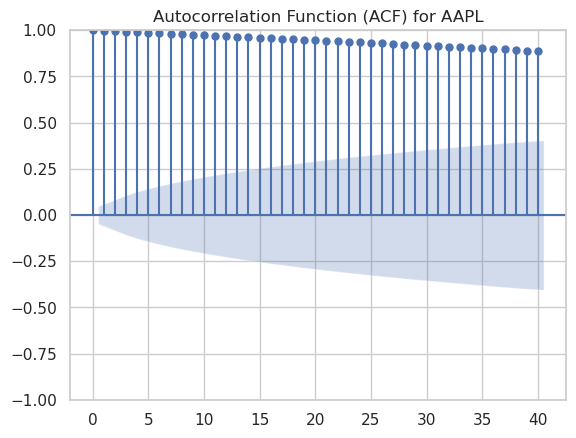

<Figure size 1200x600 with 0 Axes>

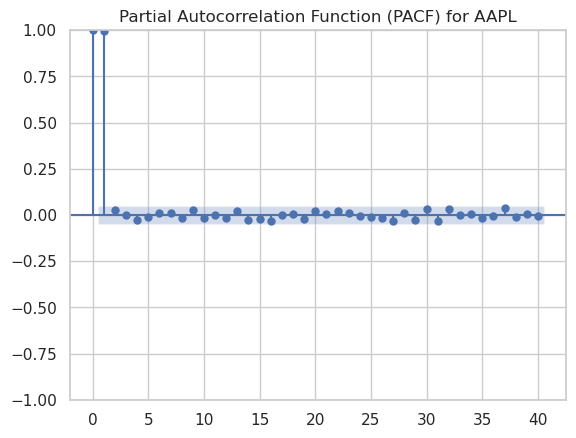

In [70]:


def plot_acf_pacf(ticker_symbol):
    # Preprocess the data (assuming the preprocess_data_arima function is defined)
    train_data, _ = preprocess_data_arima(ticker_symbol)

    # Plot ACF
    plt.figure(figsize=(12, 6))
    plot_acf(train_data, lags=40)
    plt.title('Autocorrelation Function (ACF) for ' + ticker_symbol)
    plt.show()

    # Plot PACF
    plt.figure(figsize=(12, 6))
    plot_pacf(train_data, lags=40)
    plt.title('Partial Autocorrelation Function (PACF) for ' + ticker_symbol)
    plt.show()


plot_acf_pacf('AAPL')
